###Установка необходимых библиотек

In [39]:
!pip install pandas numpy nltk spacy scikit-learn matplotlib seaborn plotly wordcloud sentence-transformers
!python -m nltk.downloader punkt stopwords
!python -m spacy download ru_core_news_sm

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Устанавливаем библиотеки для обработки данных, NLP, машинного обучения и визуализации.


Загружаем ресурсы NLTK — токенизаторы и стоп-слова.


Загружаем русскую модель Spacy для морфологического анализа.

##Импорт библиотек

In [40]:
import pandas as pd
import re
import uuid
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import numpy as np

Импортируем библиотеки для работы с данными, регулярные выражения, лемматизацию, кодирование меток, разделение выборки, классификацию, метрики, визуализацию, а также для получения эмбеддингов из моделей Sentence Transformers.

##Изучения датасета

Порядок действий:
1. Загружаем CSV-файл с отзывами (reviews.csv), кодировка cp1251 — часто используется для русского текста.
2. Выводим 15 случайных строк для первичного знакомства.
3. Считаем, сколько отзывов каждого класса (метки) содержится в датасете.
4. Строим два графика распределения меток: один статический с matplotlib + seaborn, другой — интерактивный с Plotly.

15 случайных строк из датасета:
                             Author        Date  Rating  \
120                           Елена  27.11.2023     2.0   
153                       Маргарита  08.12.2022     3.0   
244                             Ira  11.11.2024     3.0   
64                                .  07.08.2022     1.0   
208                       Анастасия  23.12.2024     3.0   
17                             Лата  02.05.2025     5.0   
3                             ольга  19.05.2025     5.0   
294                          Сокова  11.04.2025     2.0   
254                         Снежана  09.07.2024     3.0   
259                           София  09.05.2023     5.0   
51   Пользователь скрыл свои данные  19.11.2024     2.0   
223                          Ксения  19.05.2025     5.0   
274                        Цинсюань  06.04.2025     5.0   
32                            Leyla  23.03.2025     5.0   
239                          Галина  05.01.2025     4.0   

                       

<ipython-input-41-6f1a462692a6>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




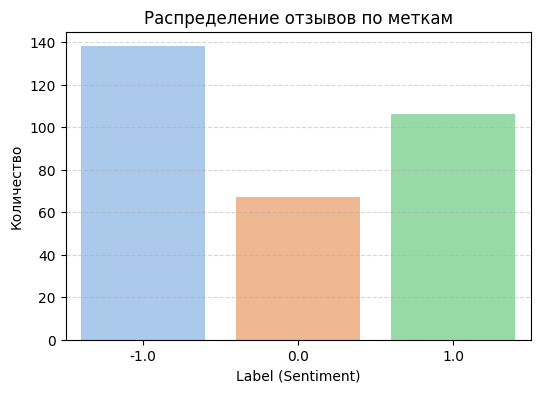

In [41]:
# Загрузка данных
df = pd.read_csv("reviews.csv", encoding='cp1251', sep=None, engine='python')

# 1. Просмотр 15 случайных строк
print("15 случайных строк из датасета:")
print(df.sample(15))

# 2. Подсчет количества каждой метки
label_counts = df['label'].value_counts().sort_index()
print("\n Количество отзывов по меткам:")
print(label_counts)

# 3. Визуализация с matplotlib
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values, palette="pastel")
plt.xlabel("Label (Sentiment)")
plt.ylabel("Количество")
plt.title("Распределение отзывов по меткам")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# 4. Визуализация с Plotly (интерактивная)
fig = px.bar(label_counts,
             title="Интерактивное распределение меток отзывов",
             labels={'index': 'Label', 'value': 'Количество'},
             color=label_counts.values,
             color_continuous_scale='Blues')
fig.update_layout(title_font_size=20, xaxis_title="Label", yaxis_title="Количество")
fig.show()

##Обработка данных + добавление id + подсчет по меткам:

Для уникальной идентификации каждой строки создаём столбец id с помощью uuid.


Удаляем колонку Author, так как она не нужна для модели.


Очищаем текст от лишних символов:

  * Удаляем одиночные буквы и цифры.

  * Убираем знаки препинания.

  * Убираем лишние пробелы.

Балансируем датасет: если есть дисбаланс между положительными и отрицательными отзывами, удаляем случайные лишние примеры из доминирующего класса, чтобы не было смещения модели.

In [11]:
# Загрузка данных
df = pd.read_csv("reviews.csv", encoding='cp1251', sep=None, engine='python')

# Генерация уникального id и замена столбца Author
df['id'] = [uuid.uuid4().hex[:8] for _ in range(len(df))]
df.drop(columns=['Author'], inplace=True)

# Очистка от лишних символов
def clean_text(text):
    text = str(text)
    text = re.sub(r'\b[a-zA-Z0-9]\b', '', text)  # удаление одиночных букв/цифр
    text = re.sub(r'[^\w\s]', '', text)          # удаление знаков препинания
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Review'] = df['Review'].apply(clean_text)

# Подсчет количества отзывов по меткам
label_counts = df['label'].value_counts()
print("Количество отзывов по меткам:")
print(label_counts)

Количество отзывов по меткам:
label
-1.0    138
 1.0    106
 0.0     67
Name: count, dtype: int64


In [12]:
# Получаем количество положительных отзывов (1)
count_1 = label_counts.get(1, 0)
count_minus1 = label_counts.get(-1, 0)

# Балансировка классов: случайно удаляем лишние -1
if count_minus1 > count_1:
    drop_count = count_minus1 - count_1
    minus1_indices = df[df['label'] == -1].sample(drop_count, random_state=42).index
    df = df.drop(index=minus1_indices)

# Подсчет после балансировки
print("\nПосле балансировки:")
print(df['label'].value_counts())


После балансировки:
label
 1.0    106
-1.0    106
 0.0     67
Name: count, dtype: int64


##Обработка текста: POS-теги, фильтрация, лемматизация

Что мы делаем:
1. Загружаем русские стоп-слова из NLTK.
2. Загружаем модель Spacy для русского языка.
3. Определяем функции для:

  - Тегирования частей речи (POS tagging).

  - Фильтрации токенов по частям речи (сохраняем прилагательные, глаголы, наречия).

  - Лемматизации и очистки токенов (приводим слова к базовой форме и удаляем стоп-слова).

4. Применяем предобработку к каждому отзыву и создаём новый столбец processed_text.

In [15]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
nlp = spacy.load("ru_core_news_sm")
lemmatizer = WordNetLemmatizer()

def tag_parts_of_speech(text):
    doc = nlp(text.lower())
    return [(token.text, token.pos_) for token in doc]

def filter_parts_of_speech(pos_tags):
    allowed = {'ADJ', 'VERB', 'ADV'}
    return " ".join([w for w, t in pos_tags if t in allowed and w not in stop_words])

def preprocess_text(text):
    doc = nlp(text.lower())
    allowed = {'ADJ', 'VERB', 'ADV'}
    tokens = [token.lemma_ for token in doc if token.pos_ in allowed and token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)

df['processed_text'] = df['Review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Кодировка меток и разделение данных

In [16]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['label'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Преобразуем текстовые метки в числовые с помощью LabelEncoder.


Делим датасет на тренировочную и тестовую части в пропорции 80/20.

##Подсчет весов слов

In [17]:
positive_words = {"хороший": 1.5, "отличный": 2.0, "радостный": 1.0}
negative_words = {"плохой": -1.5, "ужасный": -2.0, "грустный": -1.0}
neutral_words  = {"обычный": 0.5, "нормальный": 0.5}

def calculate_sentiment_weight(text):
    return sum(positive_words.get(w, 0) + negative_words.get(w, 0) + neutral_words.get(w, 0) for w in text.split())

train_df['weight'] = train_df['processed_text'].apply(calculate_sentiment_weight)
test_df['weight'] = test_df['processed_text'].apply(calculate_sentiment_weight)

Задаём словари с весами для положительных, отрицательных и нейтральных слов.


Для каждого отзыва считаем суммарный вес слов.


Добавляем эти веса в отдельные столбцы для обучения.

##Эмбеддинги с SBERT

Загружаем модель SentenceTransformer 'paraphrase-multilingual-MiniLM-L12-v2'.


Кодируем каждый отзыв из тренировочной и тестовой выборок в вектор фиксированной длины (эмбеддинг).

In [18]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
train_embeddings = model.encode(train_df['processed_text'].tolist())
test_embeddings = model.encode(test_df['processed_text'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##Обучение модели классификации

1. Для оценки модели дополнительно делим тренировочные эмбеддинги на тренировочную и валидационную части.

2. Обучаем случайный лес на тренировочных эмбеддингах.

3. Оцениваем качество на валидационной выборке, выводим точность.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(train_embeddings, train_df['sentiment'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Точность на валидационной выборке: {accuracy * 100:.2f}%")

Точность на валидационной выборке: 60.00%


##Визуализация

1. Строим матрицу ошибок (confusion matrix), чтобы понять, какие классы путаются чаще всего.

2. Строим гистограмму распределения классов.

3. Строим облака слов (WordCloud) для каждого класса, чтобы визуально увидеть часто встречающиеся слова.

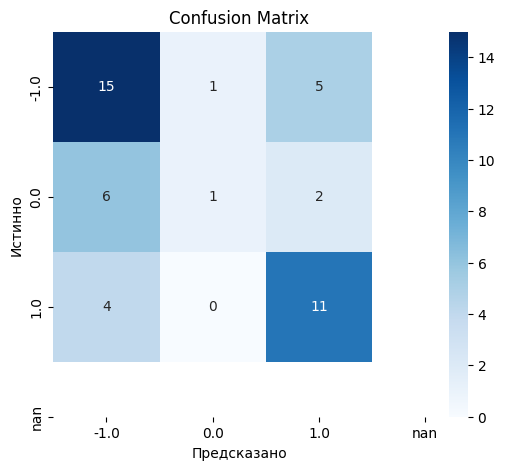

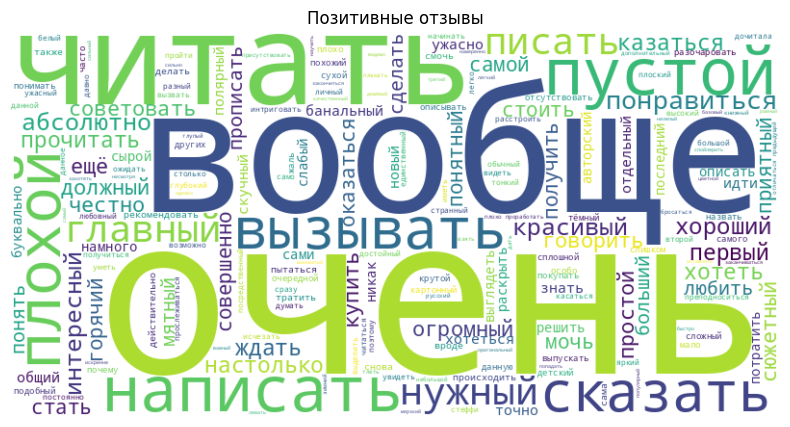

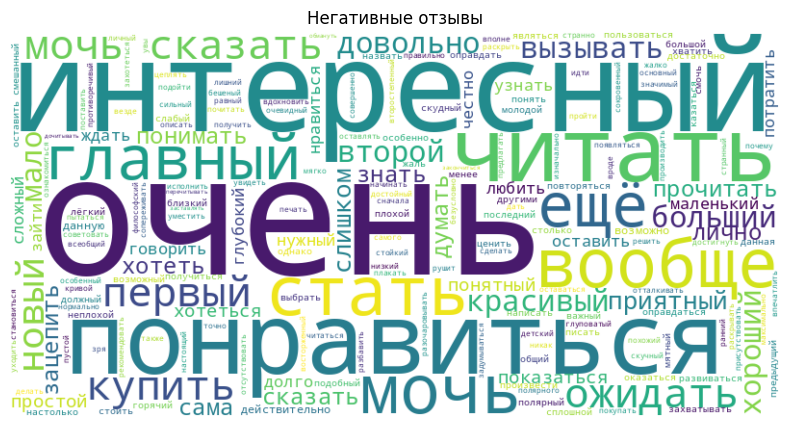

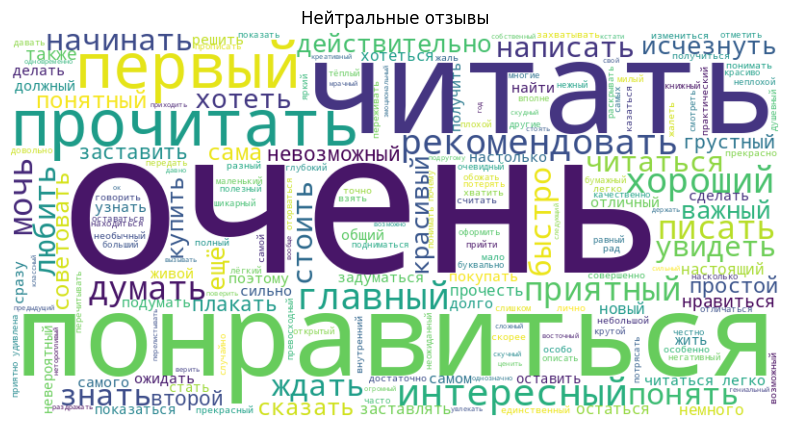

In [20]:
# Матрица ошибок
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Confusion Matrix")
plt.show()

# Гистограмма классов
fig = px.bar(train_df['label'].value_counts(), title="Распределение классов", labels={'index': 'Класс', 'value': 'Количество'})
fig.show()

# WordCloud
def plot_wordcloud(texts, title):
    text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(train_df[train_df['sentiment'] == 0]['processed_text'], "Позитивные отзывы")
plot_wordcloud(train_df[train_df['sentiment'] == 1]['processed_text'], "Негативные отзывы")
plot_wordcloud(train_df[train_df['sentiment'] == 2]['processed_text'], "Нейтральные отзывы")

##Формирование submission-файла

Что здесь происходит
- Предсказываем метки для тестовой части.
- Перекодируем предсказанные метки обратно в исходные текстовые метки.
- Сохраняем результат в CSV-файл submission.csv.

In [21]:
test_preds = classifier.predict(test_embeddings)
test_df['sentiment'] = label_encoder.inverse_transform(test_preds)

submission_df = test_df[['id', 'sentiment']]
submission_df.to_csv("submission.csv", index=False)
print("Submission.csv успешно создан!")

Submission.csv успешно создан!


##Конкурентные подходы

1. Классические подходы

| Метод                        | Преимущества                | Ограничения                           |
| ---------------------------- | --------------------------- | ------------------------------------- |
| Bag-of-Words + Naive Bayes   | Быстро, просто              | Игнорирует контекст и порядок слов    |
| TF-IDF + Logistic Regression | Простая реализация          | Ограниченное понимание семантики      |
| Random Forest / SVM          | Устойчивость к переобучению | Требуют ручного инжиниринга признаков |


Подход 1: TF-IDF + Logistic Regression

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# Загрузка ресурсов
nltk.download('stopwords')
nlp = spacy.load("ru_core_news_sm")

# Предобработка текста
stopwords_ru = set(nltk.corpus.stopwords.words('russian'))
allowed_pos = {'ADJ', 'VERB', 'ADV', 'NOUN'}

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.pos_ in allowed_pos and token.is_alpha and not token.is_stop]
    return " ".join(tokens)

# Загрузка и очистка
df = pd.read_csv("reviews.csv", encoding='cp1251', sep=None, engine='python')
df['Review'] = df['Review'].astype(str)
df['processed_text'] = df['Review'].apply(preprocess_text)

# Целевая переменная
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['label'])

# Разделение на train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
print("\n Подход 1: TF-IDF + Logistic Regression")

vectorizer1 = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf1 = vectorizer1.fit_transform(X_train_text)
X_test_tfidf1 = vectorizer1.transform(X_test_text)

clf1 = LogisticRegression(max_iter=1000, class_weight='balanced')
clf1.fit(X_train_tfidf1, y_train)
y_pred1 = clf1.predict(X_test_tfidf1)

print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1, target_names=label_encoder.classes_.astype(str)))


 Подход 1: TF-IDF + Logistic Regression
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

        -1.0       0.72      0.72      0.72        29
         0.0       0.45      0.38      0.42        13
         1.0       0.73      0.76      0.74        21
         nan       0.00      0.00      0.00         0

    accuracy                           0.67        63
   macro avg       0.48      0.47      0.47        63
weighted avg       0.67      0.67      0.67        63



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Подход 2: TF-IDF + Random Forest

In [35]:
print("\n Подход 2: TF-IDF + Random Forest")

vectorizer2 = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf2 = vectorizer2.fit_transform(X_train_text)
X_test_tfidf2 = vectorizer2.transform(X_test_text)

clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train_tfidf2, y_train)
y_pred2 = clf2.predict(X_test_tfidf2)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2, target_names=label_encoder.classes_.astype(str)))


 Подход 2: TF-IDF + Random Forest
Accuracy: 0.6031746031746031
              precision    recall  f1-score   support

        -1.0       0.59      0.76      0.67        29
         0.0       1.00      0.08      0.14        13
         1.0       0.62      0.71      0.67        21
         nan       0.00      0.00      0.00         0

    accuracy                           0.60        63
   macro avg       0.55      0.39      0.37        63
weighted avg       0.69      0.60      0.56        63



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



2 Современные подходы (на базе трансформеров)

| Модель                       | Преимущества                          | Недостатки                                |
| ---------------------------- | ------------------------------------- | ----------------------------------------- |
| BERT / RoBERTa (fine-tuning) | Высокая точность, глубинное понимание | Требует больших вычислительных ресурсов   |
| Multilingual BERT            | Поддержка многих языков               | Менее точен без дообучения                |
| SBERT                        | Быстрее и легче, чем BERT; стабилен   | Не всегда адаптируется к специфике домена |


Подход 3: SBERT (MiniLM) + Logistic Regression

In [37]:
import numpy as np
from sklearn.metrics import classification_report

In [38]:
print("\n Подход 3: SBERT (MiniLM) + Logistic Regression")

sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_train_sbert = sbert_model.encode(X_train_text.tolist(), show_progress_bar=True)
X_test_sbert = sbert_model.encode(X_test_text.tolist(), show_progress_bar=True)

clf3 = LogisticRegression(max_iter=1000, class_weight='balanced')
clf3.fit(X_train_sbert, y_train)
y_pred3 = clf3.predict(X_test_sbert)

# Получаем уникальные метки в y_test
unique_labels = np.unique(y_test)
# Декодируем их обратно в исходные метки
target_names = label_encoder.inverse_transform(unique_labels).astype(str)

print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3, labels=unique_labels, target_names=target_names))



 Подход 3: SBERT (MiniLM) + Logistic Regression


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

        -1.0       0.70      0.55      0.62        29
         0.0       0.31      0.38      0.34        13
         1.0       0.58      0.67      0.62        21

    accuracy                           0.56        63
   macro avg       0.53      0.53      0.53        63
weighted avg       0.58      0.56      0.56        63



Обоснование выбора подхода:

| Критерий              | Обоснование выбора SBERT + Logistic Regression                             |
| --------------------- | -------------------------------------------------------------------------- |
| Точность           | SBERT обеспечивает качественные эмбеддинги, которые улучшают классификацию |
| Ресурсы            | Не требует GPU или долгого обучения как при fine-tuning BERT               |
| Интерпретируемость | Logistic Regression позволяет анализировать важность признаков             |
| Быстродействие     | Быстрое обучение и применение модели на реальных данных                    |
